## Project 3: Classification of Gender based on Names

This is a collaborative project conducted by the Fall 2017 students of DATA 620 at The City University of New York, in partial fulfillment of the requirements for the MS in Data Science degree.

## Problem Description

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?  

Source: Natural Language Processing with Python, exercise 6.10.2.  



#### Contributors Include

+ K. Joy Payton  
+ Keith Folsom  
+ Sonya Hong  
+ Shyam Balagurumurthy Viswanathan  
+ Derek Nokes  
+ Liam Byrne  
+ Latif Masud  
+ Valerie Briot  

## Importing the Packages  

Since we all used Anaconda's Python version, i.e. Conda Kernel, which comes pre-installed with most of the packages we need, we can simply import them into our notebook. textstat doesn't come with the base insallation, so we have to download it before importing it:

In [ ]:
# Uncomment if textstat is not installed
#! pip install textstat

In [1]:
# Importing required libraries/packages
import nltk
from nltk.corpus import names
import random
import numpy
import pandas

from nltk.metrics import *

import re
    
import operator
import string
from textstat.textstat import textstat

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools

# set display digits
display_digits=4


# inline matplotlib
%matplotlib inline

## Obtaining the Corpus

Note: If not already executed, nltk.download() will allow you access to the names corpus

In [2]:
nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Liam\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

To start, we will use NLTK's provided library of male and female names, and shuffle our dataset:

In [3]:
names_lst = ([(name, 'male') for name in names.words('male.txt')] + \
         [(name, 'female') for name in names.words('female.txt')])

A random shuffle of the corpus lets us see a sample of the data that we will be working with.

In [5]:
random_seed=1534678
random.seed(random_seed)
random.shuffle(names_lst)

# let's see what the randomly shuffles names look like
names_lst[1:10]

[(u'Gelya', 'female'),
 (u'Dacie', 'female'),
 (u'Spud', 'male'),
 (u'Ingrid', 'female'),
 (u'Tome', 'male'),
 (u'Delora', 'female'),
 (u'Gail', 'female'),
 (u'Manfred', 'male'),
 (u'Bernd', 'male')]

## Splitting the Data

In order to develop out model, we need to split our data into three different subsets to be used for different purposes. There are 7944 names in the entire dataset. 7444 of the entries will be for development purposes (6900 for training and 500 for testing) and remaining 500 will be for testing of a final model.

##### Development set:
* 6900 names for the training (train_names)
* 500 names for the testing (devtest_names)  

##### Test set:
* 500 names for the testing (test_names)

In [6]:
test_names, devtest_names, train_names = names_lst[0:500], names_lst[500:1000], names_lst[1000:]

We confirm below that our data has been split accordingly.

In [7]:
# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_names)))
print("Dev-Test Set = {}".format(len(devtest_names)))
print("Test Set = {}".format(len(test_names)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


### Data Exploration  

We will initially explore some features of the names in order to determine if there are obvious indicators of gender. We can see the distribution of females and males in our training set as follows:

In [12]:
train_set_gold = [g  for (n, g) in train_names]
nltk.FreqDist(train_set_gold)

FreqDist({'female': 4380, 'male': 2564})

#### 1. First Letter  

An obvious feature within a name that could be a good indicator of gender would be the first letter within a name.The following will plot the frequency of first letters in regards to gender.

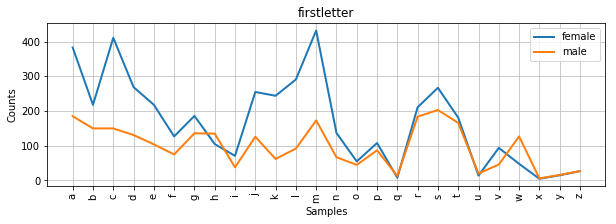

In [217]:
# firstletter
cfd_firstletter = nltk.ConditionalFreqDist(
    (gender, name[0].lower()) for name, gender in train_names)

# Normalize for male and female data
fem_count = float(len([gender for name, gender in train_names if gender == 'female']))
male_count = float(len([gender for name, gender in train_names if gender == 'male']))

for i in [counts for gender,counts in [i for i in cfd_firstletter.iteritems()] if gender == 'male']:
    for freq in i.values():
        freq = freq/male_count
        
for i in [counts for gender,counts in [i for i in cfd_firstletter.iteritems()] if gender == 'female']:
    for freq in i.values():
        freq = freq/fem_count

# define title
titleName='firstletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_firstletter.plot()

From the plot, we can observe that more female names begin with 'a', 'c', and 'm'

#### 2. Last Letter

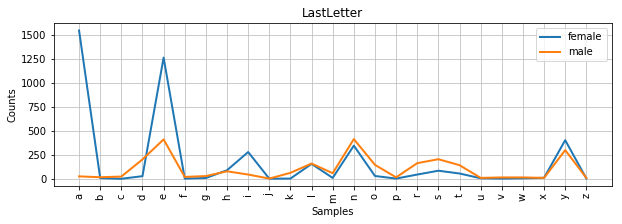

In [233]:
# lastletter
cfd_lastletter = nltk.ConditionalFreqDist(
    (gender, name[-1].lower()) for name, gender in train_names)

# define title
titleName='LastLetter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_lastletter.plot()

Names ending with letters 'a' and 'e' appear to be a good indicator of a female

#### 3. First 2 letters  

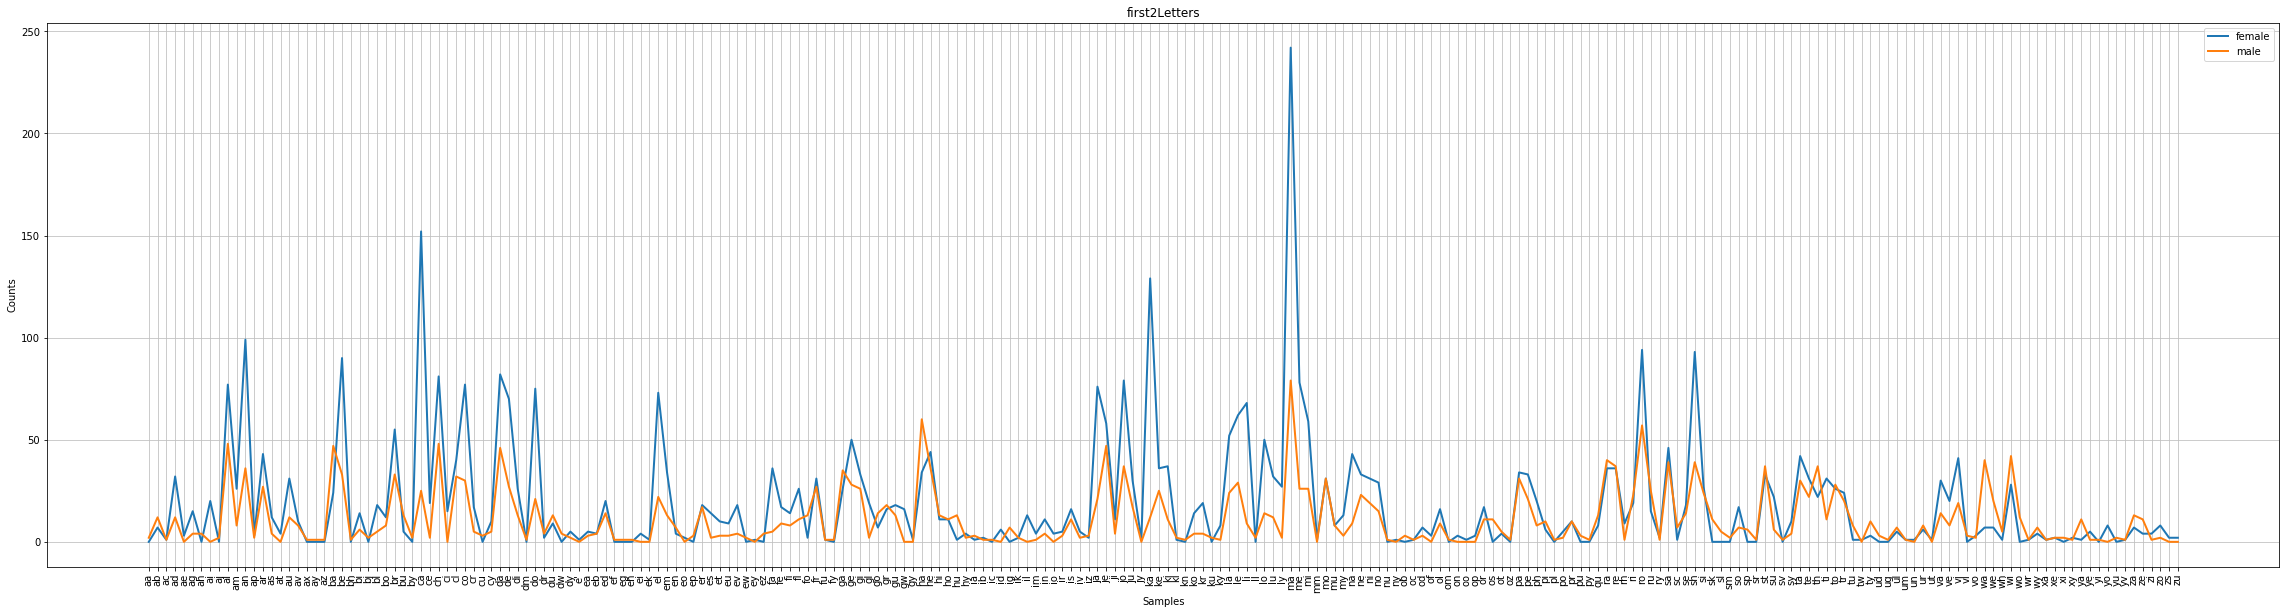

In [228]:
# first2Letters
cfd_first2Letters = nltk.ConditionalFreqDist(
    (gender, name[:2].lower()) for name, gender in train_names)

# define title
titleName='first2Letters'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_first2Letters.plot()

There seems to be some deviation in the last two letters between male and female, We will explore this feature further as it is hard to decipher from the output.

#### 4. Length  

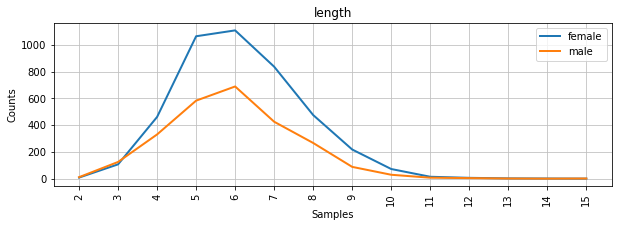

In [229]:
# length
cfd_length = nltk.ConditionalFreqDist(
    (gender, len(name)) for name, gender in train_names)

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_length.plot()

The length does not appear to be a great indicator of gender on its own.

#### 5. Vowel Counts

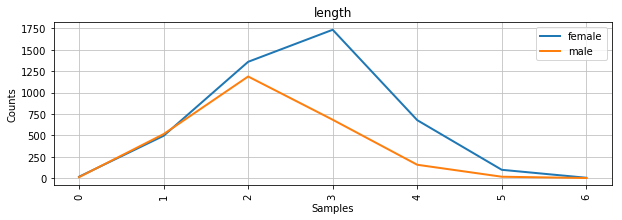

In [236]:
# Vowel Counts
cfd_vowels = nltk.ConditionalFreqDist(
    (gender, len(re.sub(r'[^aeiou]', '', name.lower()))) for name, gender in train_names)

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_vowels.plot()

The females tend to have more vowels in their name over men.

### Exploratory Conclusions

The above observations of some features was a good starting point for feature selection, but these features do not appear to be good predictors of gender on their own; we need more advanced tools in order to build a good model. We will build a feature extractor for multiple features  and then use some introductory machine learning methods to create an optimum model.

### Feature Extractor Functions

This section below is to incrementallly improve the feature extraction functions which are subsequently applied to the development and test datasets.  

Based on various example in the literature and analysis above, we will initiate our model building the the following features;  

1. First Letter, most names begining with a vowel are associated with females
2. First 2 letters
3. Last letter
4. Last 2 letters
5. Last 3 letters
6. Vowels count
7. Hard consonants using general rules of c and g
8. Soft consonants using general rules of c and g
9. Syllable Count of names via textstat
10. Name length
11. Character count
12. Character present
13. Count of each letter
14. Count of pair of letters in the alphabet

We built an function that will return a single feature or a combination of features based on input feature numbers


In [234]:
def get_features(name,feat_num):
    '''
    Parameters:
        name - string of name to extract feature
        feat_num - itterable collection of integers specifying features. *Defaults to 1:9 inclusive
            1: first letter
            2: first 2 letters
            3: last letter
            4: last 2 letters
            5: last 3 letters
            6: Vowel counts
            7: Hard consonant count
            8: Soft consonant count
            9: Syllable Count
            10: Name length
            11: char count --> feature for all alpha chars
            12: char present --> feature for all alpha chars (boolean)
            13: count each letter
            14: Count pairs
    Returns:
        features: a dictionary of extracted features
    '''
    features = {}    
        
    # Converts feat_num to itterable if type is int
    if type(feat_num) is int:
        feat_num = (0, feat_num)        
       
    # Gender Feature 1: First letter - book example
    if 1 in feat_num:
        features['firstletter'] = name[0].lower()
            
    # Gender Feature 2: First 2 letters
    if 2 in feat_num:
        features['first2Letters'] = name[0:2].lower()
            
    # Gender Feature 3: last letter
    if 3 in feat_num:
        features['last_letter'] = name[-1].lower()
            
    # Gender Feature 4: last 2 letter
    if 4 in feat_num:
        features["last2letters"] = name[-2:].lower()
        
    # Gender feature 5: last 3 letter
    if 5 in feat_num:  
        features["last3letters"] = name[-3:].lower()
            
    # Gender feature 6: Vowels count
    if 6 in feat_num:  
        features['vowel_count'] = len(re.sub(r'[^aeiou]', '', name.lower()))
            
    # Gender Feature 7: Hard consonants using general rules of c and g
    if 7 in feat_num:
        features['hard_consts'] = len(re.findall(r'[cg][^eiy]', name.lower()))/2
            
    # Gender Feature 8: Soft consonants using general rules of c and g
    if 8 in feat_num:
            features['soft_consts'] = len(re.findall(r'[cg][eiy]', name.lower()))/2
            
    # Gender Feature 9: Syllable Count of names via textstat
    if 9 in feat_num:
        features['syllable_count'] = textstat.syllable_count(name.lower())
    
    # Gender Feature 10: Name length
    if 10 in feat_num:
        features["length"] = len(name)
    
    # Gender Feature 11: Char Counts (overfitts)
    if 11 in feat_num:
        for letter in string.ascii_lowercase:
            features["count_{0}".format(letter)] = name.lower().count(letter)
                
    # Gender Feature 12: Char Booleans (overfitts)
    if 12 in feat_num:
        for letter in string.ascii_lowercase:
            features["has_{0}".format(letter)] = letter in name.lower()
        
        
    if 13 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter in letters:
            features["count(%s)" % letter] = name.lower().count(letter)


    if 14 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            for letter2 in letters:
                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())
        
    #### Complex Features
    # Gender Feature 15: Last Letter/Last 2 Letter
    if 15 in feat_num:
        features = {}
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
            
    if 16 in feat_num:
        features = {}
        features["firstletter"] = name[0].lower()
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
        features["last3letter"] = name[-3:].lower()

        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            features["count("+letter1+")"] = name.lower().count(letter1)
            features["has("+letter1+")"] = (letter1 in name.lower())
            # iterate over 2-grams
            for letter2 in letters:

                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())


    if 17 in feat_num:
        # define features
        features = {}
        # has(fo) = True
        features["has(fo)"] = ('fo' in name.lower())
        # has(hu) = True
        features["has(hu)"] = ('hu' in name.lower())
        # has(rv) = True
        features["has(rv)"] = ('rv' in name.lower())    
        # has(rw) = True
        features["has(rw)"] = ('rw' in name.lower()) 
        # has(sp) = True
        features["has(sp)"] = ('sp' in name.lower())

        # lastletter = 'a'
        features["lastletter=a"] = ('a' in name[-1:].lower())
        # lastletter = 'f'
        features["lastletter=f"] = ('f' in name[-1:].lower())
        # lastletter = 'k'
        features["lastletter=k"] = ('k' in name[-1:].lower())

        # last2letter = 'ch'
        features["last2letter=ch"] = ('ch' in name[-2:].lower())
        # last2letter = 'do'
        features["last2letter=do"] = ('do' in name[-2:].lower())
        # last2letter = 'ia'
        features["last2letter=ia"] = ('ia' in name[-2:].lower())
        # last2letter = 'im'
        features["last2letter=im"] = ('im' in name[-2:].lower())
        # last2letter = 'io'
        features["last2letter=io"] = ('io' in name[-2:].lower())
        # last2letter = 'la'
        features["last2letter=la"] = ('la' in name[-2:].lower())
        # last2letter = 'ld'
        features["last2letter=ld"] = ('ld' in name[-2:].lower())
        # last2letter = 'na'
        features["last2letter=na"] = ('na' in name[-2:].lower())
        # last2letter = 'os'
        features["last2letter=os"] = ('os' in name[-2:].lower())
        # last2letter = 'ra'
        features["last2letter=ra"] = ('ra' in name[-2:].lower())
        # last2letter = 'rd'
        features["last2letter=rd"] = ('rd' in name[-2:].lower())
        # last2letter = 'rt'
        features["last2letter=rt"] = ('rt' in name[-2:].lower())
        # last2letter = 'sa'
        features["last2letter=sa"] = ('sa' in name[-2:].lower())
        # last2letter = 'ta'
        features["last2letter=ta"] = ('ta' in name[-2:].lower())
        # last2letter = 'us'
        features["last2letter=us"] = ('us' in name[-2:].lower())

        # last3letter = 'ana'
        features["last3letter=ana"] = ('ana' in name[-3:].lower())    
        # last3letter = u'ard'
        features["last3letter=ard"] = ('ard' in name[-3:].lower())        
        # last3letter = u'ita'
        features["last3letter=ita"] = ('ita' in name[-3:].lower())    
        # last3letter = u'nne'
        features["last3letter=nne"] = ('nne' in name[-3:].lower())    
        # last3letter = u'tta'
        features["last3letter=tta"] = ('tta' in name[-3:].lower())    
        
    return features



### Functions for analysis and Helper functions

We built a few functions that will faciliate the analysis and the display of the results;

+ normalize_confusion_matrix: Returns a normalized confusion matrix  
+ plot_confusion_matrix: plot a confusion matrix 
+ plot_both_confusion_matrix: plot 2 confusion matrix side by side  
+ evaluate_naive_bayes_classifier: train a model using naive bayes classifier  
+ evaluate_decision_tree_classifier: train a model using decision tree classifier
+ get_sorted_feature_accuracies: Returns a tuple of sorted features and accuracies in the dataset.
+ optmized_solution: Returns a tuple of list of features that yield the highest accuracy, and the accuracy that was achieved.

Helper functions:  

+ generate_errors
+ show_errors
+ generate_prediction

In [237]:
### Functions for analysis
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

def evaluate_naive_bayes_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set) 
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier

def evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.DecisionTreeClassifier.train(train_set)
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier
 
    
def get_sorted_feature_accuracies(feat_num_start, feat_num, model_id):
        feature_accuracy = {}
        for i in numpy.arange(feat_num_start, feat_num+1):
            feat_num =int(i)
            errors = []
            
            # devtest-set and training set are constructed
            #random.shuffle(development_set_names)
            #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
            train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
            devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
            test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names] 
            
            if (model_id == 'nbc'):
                classifier = nltk.NaiveBayesClassifier.train(train_set)
            elif (model_id == 'dtc'):
                classifier = nltk.DecisionTreeClassifier.train(train_set)
                  
            # For errors list
            for (name, tag) in devtest_names:
                guess = classifier.classify(get_features(name,feat_num)) 
                if guess != tag: 
                    errors.append((tag, guess, name))    
                    
            
            feature_accuracy[feat_num] = nltk.classify.accuracy(classifier, devtest_set)
        
        
        #sort for accuracy, and then reverse the array to return the array as most accurate to least accurate
        sorted_by_accuracy = sorted(feature_accuracy.items(), key=operator.itemgetter(1))
        return sorted_by_accuracy[::-1]
                  
def optimized_solution(model_id):
    # for each of the features, append to the list of features, and check if the accuracy
    #went up or down. If it went down, take it out, if it went up, make that the new accuracy to beat.
        
    optimized_feature_list = []
    last_accuracy = -1
    for feat_num in range(1,15):
        errors = []
        optimized_feature_list.append(feat_num)
            
        #random.shuffle(development_set_names)
        #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
        train_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in train_names]
        devtest_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in devtest_names]
        test_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in test_names] 
            
        if (model_id == 'nbc'):
            classifier = nltk.NaiveBayesClassifier.train(train_set)
        elif (model_id == 'dtc'):
            classifier = nltk.DecisionTreeClassifier.train(train_set) 
            
        for (name, tag) in devtest_names:
            guess = classifier.classify(get_features(name,optimized_feature_list)) 
            if guess != tag: 
                errors.append((tag, guess, name))    
                    
            
        current_accuracy= nltk.classify.accuracy(classifier, devtest_set)
        if current_accuracy > last_accuracy: 
            last_accuracy = current_accuracy
        else:
            del optimized_feature_list[-1]
            
    return (optimized_feature_list, last_accuracy)     

### Helper functions:

# Generic function to generate an error list based the arguments provided
# Accepts the classifer, names dataset, and the extractor function
# Returns the list of errors

def generate_errors(classifier, dataset, feat_num): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name,feat_num)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

# Generic function to display classification errors
# Accepts the error list and an optional argument to show only n number of errors

def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

        
def generate_prediction(classifier, dataset, extractor_function): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        classification.append((name,guess))
            
    return classification

### Gender Identification Models - Naive Bayes Classifier: 

Using our previously identified simple features we will evaluate how the model perform for each.  

#### Feature 1 - First Letter

In this model, we train a Naive Bayes classifier using a simple feature set - namely the first letter of the name.

Accuracy (Train): 0.648329493088
Accuracy (Development Test): 0.634


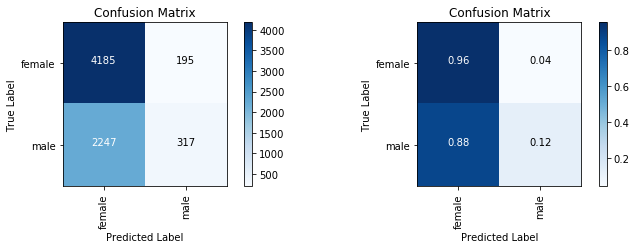

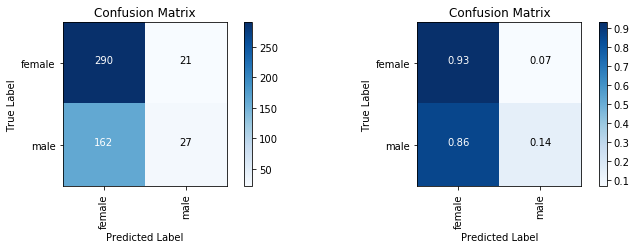

In [238]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb1,train_cm_nb1,train_label_names_nb1,train_report_nb1, \
    devtest_accuracy_nb1, devtest_cm_nb1,devtest_label_names_nb1, \
    devtest_report_nb1, classifier_nb1=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb1))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb1,['female','male'])

In [239]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb1)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6507    0.9555    0.7741      4380
       male     0.6191    0.1236    0.2061      2564

avg / total     0.6390    0.6483    0.5644      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6416    0.9325    0.7602       311
       male     0.5625    0.1429    0.2278       189

avg / total     0.6117    0.6340    0.5589       500



In [240]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb1.show_most_informative_features(n_informative_features)

Most Informative Features
             firstletter = u'w'             male : female =      4.5 : 1.0
             firstletter = u'q'             male : female =      2.7 : 1.0
             firstletter = u'u'             male : female =      2.4 : 1.0
             firstletter = u'k'           female : male   =      2.3 : 1.0
             firstletter = u'h'             male : female =      2.2 : 1.0
             firstletter = u'x'             male : female =      2.0 : 1.0
             firstletter = u'l'           female : male   =      1.8 : 1.0
             firstletter = u'y'             male : female =      1.8 : 1.0
             firstletter = u'z'             male : female =      1.7 : 1.0
             firstletter = u'c'           female : male   =      1.6 : 1.0
             firstletter = u't'             male : female =      1.6 : 1.0
             firstletter = u'r'             male : female =      1.5 : 1.0
             firstletter = u'm'           female : male   =      1.5 : 1.0

In [241]:
# Show error 
show_errors(generate_errors(classifier_nb1, devtest_names, feat_num))

correct=female   guess=male     name=Harmony                       
correct=female   guess=male     name=Harri                         
correct=female   guess=male     name=Harrietta                     
correct=female   guess=male     name=Harriette                     
correct=female   guess=male     name=Harriot                       
correct=female   guess=male     name=Harriott                      
correct=female   guess=male     name=Helen-Elizabeth               
correct=female   guess=male     name=Hendrika                      
correct=female   guess=male     name=Hertha                        
correct=female   guess=male     name=Hildy                         
correct=female   guess=male     name=Honey                         
correct=female   guess=male     name=Horatia                       
correct=female   guess=male     name=Quintana                      
correct=female   guess=male     name=Waly                          
correct=female   guess=male     name=Wilhelmina 

First letter alone does not lead to very good results as is indicated by the analysis above.  

#### Feature 2 - First 2 letters  

We will now consider the first 2 letters as our feature.  


In [ ]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb2,train_cm_nb2,train_label_names_nb2,train_report_nb2, \
    devtest_accuracy_nb2, devtest_cm_nb2,devtest_label_names_nb2, \
    devtest_report_nb2, classifier_nb2=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb2))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb2,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb2.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb2, devtest_names, feat_num))

First letters features are not good candidate for building model, we will now consider last letter(s) features.  

#### Feature 3 - Last letter

We will now focus on the last letter of the name. In our brief exploration of features, we observed some patterns that could likely be exploited by our classifier.

In [ ]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb3,train_cm_nb3,train_label_names_nb3,train_report_nb3, \
    devtest_accuracy_nb3, devtest_cm_nb3,devtest_label_names_nb3, \
    devtest_report_nb3, classifier_nb3=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb3))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb3,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb3.show_most_informative_features(n_informative_features)

In [ ]:
show_errors(generate_errors(classifier_nb3, devtest_names, feat_num))

Although names ending in the letter 'a' is our second best feature in this feature set, the other rules that looked useful in gender prediction were not in the top of the list.

This is perhaps because we explored the conditional frequency, rather than the percent conditional frequency.

#### Feature 4 - Last 2 letters  

In this model, we train a Naive Bayes classifier using a feature set comprised of the first two letters of a name.

In [ ]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb4,train_cm_nb4,train_label_names_nb4,train_report_nb4, \
    devtest_accuracy_nb4, devtest_cm_nb4,devtest_label_names_nb4, \
    devtest_report_nb4, classifier_nb4=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb4))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb4,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb4.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb4, devtest_names, feat_num))

Feature utilizating last letter(s) leads better results so far.  

#### Feature 5 - Last 3 Letters  

In this model, we train a Naive Bayes classifier using the last three letters of the name.

In [ ]:
feat_num = 5
# evaluate the Naive Bayes classifier using gender_features5
train_accuracy_nb5,train_cm_nb5,train_label_names_nb5,train_report_nb5, \
    devtest_accuracy_nb5, devtest_cm_nb5,devtest_label_names_nb5, \
    devtest_report_nb5, classifier_nb5=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb5))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb5,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb5.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb5, devtest_names, feat_num))

#### Feature 6 - Vowels Count  

In this model, we train a Naive Bayes classifier using the vowel count.

In [ ]:
feat_num = 6
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb6,train_cm_nb6,train_label_names_nb6,train_report_nb6, \
    devtest_accuracy_nb6, devtest_cm_nb6,devtest_label_names_nb6, \
    devtest_report_nb6, classifier_nb6=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb6))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb6,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb6.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb6, devtest_names, feat_num))

This feature is not leading as good results as last letter features.  

#### Feature 7 - Hard Consonant using general rules of c and g  

In this model, we train a Naive Bayes classifier based on hard consonants using general rules of 'c' and 'g'.

In [ ]:
feat_num = 7
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb7,train_cm_nb7,train_label_names_nb7,train_report_nb7, \
    devtest_accuracy_nb7, devtest_cm_nb7,devtest_label_names_nb7, \
    devtest_report_nb7, classifier_nb7=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb7))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb7,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb7.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb7, devtest_names, feat_num))

Again, this feature does not look promising as a first feature to build our model on.  

#### Feature 8 - Soft Consonant using general rules of c and g  

In this model, we train a Naive Bayes classifier based on soft consonants using general rules of 'c' and 'g'.

In [ ]:
feat_num = 8
# evaluate the Naive Bayes classifier using gender_features8
train_accuracy_nb8,train_cm_nb8,train_label_names_nb8,train_report_nb8, \
    devtest_accuracy_nb8, devtest_cm_nb8,devtest_label_names_nb8, \
    devtest_report_nb8, classifier_nb8=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb8))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb8,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb8.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb8, devtest_names, feat_num))

#### Feature 9 - Syllable Count  

In this model, we train a Naive Bayes classifier using the syllable count.

In [ ]:
feat_num = 9
# evaluate the Naive Bayes classifier using gender_features9
train_accuracy_nb9,train_cm_nb9,train_label_names_nb9,train_report_nb9, \
    devtest_accuracy_nb9, devtest_cm_nb9,devtest_label_names_nb9, \
    devtest_report_nb9, classifier_nb9=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb9))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb9,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb9.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb9, devtest_names, feat_num))

#### Feature 10 - Name Length  

In this model, we train a Naive Bayes classifier using the name length.

In [ ]:
feat_num = 10
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb10,train_cm_nb10,train_label_names_nb10,train_report_nb10, \
    devtest_accuracy_nb10, devtest_cm_nb10,devtest_label_names_nb10, \
    devtest_report_nb10, classifier_nb10=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb10))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb10,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb10.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb10, devtest_names, feat_num))

#### Feature 11 - Character Count  

In this model, we train a Naive Bayes classifier using a character count.  

In [ ]:
feat_num = 11
# evaluate the Naive Bayes classifier using gender_features11
train_accuracy_nb11,train_cm_nb11,train_label_names_nb11,train_report_nb11, \
    devtest_accuracy_nb11, devtest_cm_nb11,devtest_label_names_nb11, \
    devtest_report_nb11, classifier_nb11=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb11))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb11))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb11,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb11,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb11.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb11, devtest_names, feat_num))

#### Feature 12 - Character Present  

In this model, we train a Naive Bayes classifier using presence of charcters.

In [ ]:
feat_num = 12
# evaluate the Naive Bayes classifier using gender_features12
train_accuracy_nb12,train_cm_nb12,train_label_names_nb12,train_report_nb12, \
    devtest_accuracy_nb12, devtest_cm_nb12,devtest_label_names_nb12, \
    devtest_report_nb12, classifier_nb12=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb12))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb12))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb12,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb12,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb12.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb12, devtest_names, feat_num))

#### Feature 13 - Count of each letter   

In this model, we train a Naive Bayes classifier using the count of each letter.

In [ ]:
feat_num = 13
# evaluate the Naive Bayes classifier using gender_features13
train_accuracy_nb13,train_cm_nb13,train_label_names_nb13,train_report_nb13, \
    devtest_accuracy_nb13, devtest_cm_nb13,devtest_label_names_nb13, \
    devtest_report_nb13, classifier_nb13=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb13))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb13))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb13,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb13,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb13.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb13, devtest_names, feat_num))

#### Feature 14 - Count of Pair of letters  

In this model, we train a Naive Bayes classifier using the count of pair of letters.

In [ ]:
feat_num = 14
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb14,train_cm_nb14,train_label_names_nb14,train_report_nb14, \
    devtest_accuracy_nb14, devtest_cm_nb14,devtest_label_names_nb14, \
    devtest_report_nb14, classifier_nb14=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb14))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb14))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb14,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb14,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb14.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb14, devtest_names, feat_num))

#### Features Optimization    

In order to build the best possible Naive Baeyes Module, we will identify the best features based on accuracy rating.  


In [ ]:
ranked_features = get_sorted_feature_accuracies(1, 14, 'nbc')

In [ ]:
features = {
    1: "First Letter",
    2: "First 2 Letters",
    3: "Last Letter", 
    4: "Last 2 Letters", 
    5: "Last 3 Letters", 
    6: "Vowels count",
    7: "Hard consonants using general rules of c and g",
    8: "Soft consonants using general rules of c and g",
    9: "Syllable Count of names via textstat",
    10: "Name length",
    11: "Character count",
    12: "Character present",
    13: "Count of each letter",
    14: "Count of pair of letters in the alphabet",
}

print("Top Five Single Features with the Highest Accuracy")
print("---------------------------------------------------------------")
for (feat_num, accuracy) in ranked_features[0:5]:
    print('Feature: %-30s Accuracy: %-8s' %(features[feat_num], accuracy))

print("---------------------------------------------------------------")

Combining different features together can often lead to a more accurate classification system. The optmize_solution function was built to go through different combinations of classification features, and yield out a result of features that lead to the most accurate solution:

In [ ]:
optimized_features = optimized_solution('nbc')
optimized_features


We see that the optmized solution yielded an accuracy of 0.83, while the highest accuracy achieved by any single feature was 0.786. The following features provided the optimized solution:

In [ ]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

#### Complext Features Evaluation  

Based on the single features evaluation, we developped some complext features that will will now evaluate.  

##### Feature 15 - Last Letter / Last 2 Letter  

In this model, we train a Naive Bayes classifier using the last letter of the name and the last two letters of a name.

In [ ]:
feat_num = 15
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb15,train_cm_nb15,train_label_names_nb15,train_report_nb15, \
    devtest_accuracy_nb15, devtest_cm_nb15,devtest_label_names_nb15, \
    devtest_report_nb15, classifier_nb15=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb15))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb15))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb15,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb15,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb15.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb15, devtest_names, feat_num))

##### Feature 16 - Complex Combine Feature

In this model, we train a Naive Bayes classifier using a feature set composed the first letter, the last letter, the last two letters, the last 3 letters, the letter count, the presence of a letter, and all two letter combinations.

In [ ]:
feat_num = 16
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb16,train_cm_nb16,train_label_names_nb16,train_report_nb16, \
    devtest_accuracy_nb16, devtest_cm_nb16,devtest_label_names_nb16, \
    devtest_report_nb16, classifier_nb16=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb16))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb16))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb16,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb16.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb16, devtest_names, feat_num))

Despite the large feature set, the performance of our model is relatively good on both the training and development test data sets.

#### Best Model for Naive Bayes Classifier  

We will now compare the best model we build using our manually constructed complex feature and the feature constructed as a result of our optimization process and compare.  

The features included as the result of the optimization analysis are:  

In [ ]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

In [ ]:
feat_num = [1, 3, 4, 5, 6, 11]
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb17,train_cm_nb17,train_label_names_nb17,train_report_nb17, \
    devtest_accuracy_nb17, devtest_cm_nb17,devtest_label_names_nb17, \
    devtest_report_nb17, classifier_nb17=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb17))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb17))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb17,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb17,['female','male'])

In [ ]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb17.show_most_informative_features(n_informative_features)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_nb17, devtest_names, feat_num))

Our Manually constructed complext feature, Feature 16 provides slighly better results and will be the one selected for the Naive Bayes Classifier.  

### Gender Identification Models - Decision Tree Classifier: 

Using our previously identified simple features we will evaluate how the model perform for each.  

#### Feature 1 - First Letter

In this model, we train a Decision Tree classifier using a simple feature set - namely the first letter of the name.

In [ ]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt1,train_cm_dt1,train_label_names_dt1,train_report_dt1,devtest_accuracy_dt1, devtest_cm_dt1,devtest_label_names_dt1,devtest_report_dt1, classifier_dt1=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt1))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt1,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt1)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt1, devtest_names, feat_num))

#### Feature 2 - First 2 Letters  

In this model, we train a Decision Tree classifier using the first 2 letters of the name.

In [ ]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_dt2,train_cm_dt2,train_label_names_dt2,train_report_dt2,devtest_accuracy_dt2, devtest_cm_dt2,devtest_label_names_dt2,devtest_report_dt2, classifier_dt2=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt2))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt2,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt2)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt2)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt2, devtest_names, feat_num))

#### Feature 3 - Last Letter  

In this model, we train a Decision Tree classifier using the last letter of the name.

In [ ]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features3
train_accuracy_dt3,train_cm_dt3,train_label_names_dt3,train_report_dt3,devtest_accuracy_dt3, devtest_cm_dt3,devtest_label_names_dt3,devtest_report_dt3, classifier_dt3=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt3))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt3,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt3)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt3)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt3, devtest_names, feat_num))

#### Feature 4 - Last 2 Letters  

In this model, we train a Decision Tree classifier using the last 2 letters of the name.

In [ ]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt4,train_cm_dt4,train_label_names_dt4,train_report_dt4,devtest_accuracy_dt4, devtest_cm_dt4,devtest_label_names_dt4,devtest_report_dt4, classifier_dt4=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt4))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt4,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt4)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt4)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt4, devtest_names, feat_num))

#### Feature 5 - Last 3 Letters  

In this model, we train a Decision Tree classifier using the last 3 letters of the name.

In [ ]:
feat_num = 5
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt5,train_cm_dt5,train_label_names_dt5,train_report_dt5,devtest_accuracy_dt5, devtest_cm_dt5,devtest_label_names_dt5,devtest_report_dt5, classifier_dt5=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt5))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt5,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt5)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt5)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt5, devtest_names, feat_num))

#### Feature 6 - Vowels Count  

In this model, we train a Decision Tree classifier using a vowel count the name.

In [ ]:
feat_num = 6
# evaluate the Naive Bayes classifier using gender_features6
train_accuracy_dt6,train_cm_dt6,train_label_names_dt6,train_report_dt6,devtest_accuracy_dt6, devtest_cm_dt6,devtest_label_names_dt6,devtest_report_dt6, classifier_dt6=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt6))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt6,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt6)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt6)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt6, devtest_names, feat_num))

#### Feature 7 - Hard consonants using general rules of c and g  

In this model, we train a Decision Tree classifier Hard consonants using general rules of c and g.

In [ ]:
feat_num = 7
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt7,train_cm_dt7,train_label_names_dt7,train_report_dt7,devtest_accuracy_dt7, devtest_cm_dt7,devtest_label_names_dt7,devtest_report_dt7, classifier_dt7=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt7))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt7,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt7)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt7)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt7, devtest_names, feat_num))

#### Feature 8 - Soft Consonants  using general rules of c and g 

In this model, we train a Decision Tree classifier using soft consonants using general rules of c and g.

In [ ]:
feat_num = 8
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_dt8,train_cm_dt8,train_label_names_dt8,train_report_dt8,devtest_accuracy_dt8, devtest_cm_dt8,devtest_label_names_dt8,devtest_report_dt8, classifier_dt8=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt8))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt8,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt8)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt8)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt8, devtest_names, feat_num))

#### Feature 9 - Syllable Count  

In this model, we train a Decision Tree classifier using syllable count.

In [ ]:
feat_num = 9
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt9,train_cm_dt9,train_label_names_dt9,train_report_dt9,devtest_accuracy_dt9, devtest_cm_dt9,devtest_label_names_dt9,devtest_report_dt9, classifier_dt9=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt9))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt9,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt9)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt9)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt9, devtest_names, feat_num))

#### Feature 10 - Name length  

In this model, we train a Decision Tree classifier using name length.

In [ ]:
feat_num = 10
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt10,train_cm_dt10,train_label_names_dt10,train_report_dt10,devtest_accuracy_dt10, devtest_cm_dt10,devtest_label_names_dt10,devtest_report_dt10, classifier_dt10=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt10))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt10,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt10)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt10)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt10, devtest_names, feat_num))

#### Feature 11 - Character Count  

In this model, we train a Decision Tree classifier using character count.

In [ ]:
feat_num = 11
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt11,train_cm_dt11,train_label_names_dt11,train_report_dt11,devtest_accuracy_dt11, devtest_cm_dt11,devtest_label_names_dt11,devtest_report_dt11, classifier_dt11=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt11))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt11))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt11,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt11,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt11)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt11)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt11, devtest_names, feat_num))

#### Feature 12 - Character Present  

In this model, we train a Decision Tree classifier using character being present in name.

In [ ]:
feat_num = 12
# evaluate the Decision Tree classifier using gender_features10
train_accuracy_dt12,train_cm_dt12,train_label_names_dt12,train_report_dt12,devtest_accuracy_dt12, devtest_cm_dt12,devtest_label_names_dt12,devtest_report_dt12, classifier_dt12=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt12))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt12))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt12,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt12,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt12)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt12)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt12, devtest_names, feat_num))

#### Feature 13 - Count of each Letter  

In this model, we train a Decision Tree classifier using a count of each letter.  

In [ ]:
feat_num = 13
# evaluate the Decision Tree classifier using gender_features13
train_accuracy_dt13,train_cm_dt13,train_label_names_dt13,train_report_dt13,devtest_accuracy_dt13, devtest_cm_dt13,devtest_label_names_dt13,devtest_report_dt13, classifier_dt13=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt13))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt13))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt13,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt13,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt13)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt13)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt13, devtest_names, feat_num))

#### Feature 14 - Count of pair of letters in the alphabet  

In this model, we train a Decision Tree classifier using count of each pair of letters in the alphabet.

In [ ]:
feat_num = 14
# evaluate the Decision Tree classifier using gender_features14
train_accuracy_dt14,train_cm_dt14,train_label_names_dt14,train_report_dt14,devtest_accuracy_dt14, devtest_cm_dt14,devtest_label_names_dt14,devtest_report_dt14, classifier_dt14=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt14))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt14))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt14,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt14,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt14)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt14)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt14, devtest_names, feat_num))

#### Features Optimization  

In order to build the best possible Naive Baeyes Module, we will identify the best features based on accuracy rating.


In [ ]:
ranked_features = get_sorted_feature_accuracies(1, 14, 'dtc')

In [ ]:
features = {
    1: "First Letter",
    2: "First 2 Letters",
    3: "Last Letter", 
    4: "Last 2 Letters", 
    5: "Last 3 Letters", 
    6: "Vowels count",
    7: "Hard consonants using general rules of c and g",
    8: "Soft consonants using general rules of c and g",
    9: "Syllable Count of names via textstat",
    10: "Name length",
    11: "Character count",
    12: "Character present",
    13: "Count of each letter",
    14: "Count of pair of letters in the alphabet",
}

print("Top Five Single Features with the Highest Accuracy")
print("---------------------------------------------------------------")
for (feat_num, accuracy) in ranked_features[0:5]:
    print('Feature: %-30s Accuracy: %-8s' %(features[feat_num], accuracy))

print("---------------------------------------------------------------")

In [ ]:
optimized_features = optimized_solution('dtc')
optimized_features


We see that the optmized solution yielded an accuracy of 0.774, while the highest accuracy achieved by any single feature was 0.79. It appear, that we have a case of overfitting with our optimization option for decision tree classifier.  
We will not used this feature set for best model for decision tree classifier.  

The following features provided the optimized solution:

In [ ]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

#### Complext Features Evaluation  

Based on the single features evaluation, we developped some complext features that will will now evaluate.  

##### Feature 15 - Last Letter / Last 2 Letter  

In this model, we train a Decision Tree classifier using the last letter of the name and the last two letters of a name.

In [ ]:
feat_num = 15
# evaluate the Decision Tree classifier using gender_features15
train_accuracy_dt15,train_cm_dt15,train_label_names_dt15,train_report_dt15,devtest_accuracy_dt15, devtest_cm_dt15,devtest_label_names_dt15,devtest_report_dt15, classifier_dt15=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt15))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt15))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt15,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt15,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt15)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt15)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt15, devtest_names, feat_num))

#### Feature 16 - Complex Combination Feature  

In this model, we train a Decision Tree classifier using a feature set composed the first letter, the last letter, the last two letters, the last 3 letters, the letter count, the presence of a letter, and all two letter combinations.

In [ ]:
feat_num = 16
# evaluate the Decision Tree classifier using gender_features16
train_accuracy_dt16,train_cm_dt16,train_label_names_dt16,train_report_dt16,devtest_accuracy_dt16, devtest_cm_dt16,devtest_label_names_dt16,devtest_report_dt16, classifier_dt16=evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num)
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_dt16))
print('Accuracy (Development Test): '+str(devtest_accuracy_dt16))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_dt16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_dt16,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_dt16)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_dt16)

In [ ]:
# Show error 
show_errors(generate_errors(classifier_dt16, devtest_names, feat_num))

The large difference between the performance on the training and development test data sets is a clear indication of over-fitting. Recall that we generally observed a much smaller difference in the performance between the training and development test sets for Naive Bayes classifiers. This is an expected result. The overall performance of a Naive Bayes classifier can be improved with the inclusion of weak features, while the performance of the Decision Tree classifier cannot by construction.

The best results we got for the Decision Tree classifier was with combination Feature 15.  However, these results are under pare with respect to the results we got with the Naive Bayes Classifier (Feature 16).  

We will there select this model as the best.  

### Model Selection (Choose Best Candidate) 

#### Check the model's final performance on the test set. 

In [ ]:
# create test set (final test)
feat_num = 16
test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
# extract actual classes (gold)
test_set_gold_nb16 = [g  for (n, g) in test_names]

# create predicted classes (test)
test_set_predictions_nb16 = [classifier_nb16.classify(get_features(n,feat_num))  for (n, g) in test_names]
# compute accuracy (test set)
test_accuracy_nb16=nltk.classify.accuracy(classifier_nb16, test_set)

# create confusion matrix
test_cm_nb16=confusion_matrix(test_set_gold_nb16, test_set_predictions_nb16)
# get unique classes (train)
test_label_names_nb16 =  list(set(test_set_gold_nb16) | set(test_set_predictions_nb16))    
# create table with precision, recall, f1-score, and support
test_report_nb16=classification_report(test_set_gold_nb16, test_set_predictions_nb16,
    digits=display_digits)

In [ ]:
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb16))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb16))
print('Accuracy (Final Test): '+str(test_accuracy_nb16))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb16,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(test_cm_nb16,['female','male'])

In [ ]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb16)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb16)
# display performance report (test)
print('Model Performance Metrics (Test):')
print(test_report_nb16)

#### How does the performance on the test set compare to the performance on the dev-test set? 

We can see that our model performance degrades on predictions of male names as we move from the training data set to development test data set, then again from the development test data set to the final test data set. The performance degradation is less apparent on female names.

The proportion of female names is roughly the same across the training, development test, and final test data sets (62.6%, 65.2%, and 65.4% respectively). The slightly higher proportion of female names in the development test and final test data sets likely improves our performance marginally.

#### Is this what you'd expect?

### Group Project Lessons Learned

We came together very well as a group. We used www.slack.com and www.github.com to communicate and share our work.  Our efforts were a little disjointed.  Possibly because we come together on within one week of the due date of the project (thank you Karen for kick starting the project) and we jump in with producing code.  Had we a chance to allocate the work better in the prior week, we may had a better work organization.  Also, we may have been a little timid in electing a person to act as a "pm".  Finally, some of us had problem using github and we did not fully make use of the version controlling features that it offered which make compiling a final document a little bit more difficult.  

#### Take-aways  
+ Some beforehand planning
+ Mastering Github